In [34]:

def print_dict(data):
    for key, value in data.items():
        print(f"\n[ {key.upper()} ]")
        for metric, val in value.items():
            if metric == "confusion_matrix":
                print(f"  {metric}:")
                for row in val:
                    print(f"    {row}")
            else:
                print(f"  {metric}: {val:.3f}")

def print_dict2(data, _):
    string = ''
    for key, value in data.items():
        if key == 'train':
            string += (f'( {_} )')
            
        string += f"\n[ {key.upper()} ]"
        for metric, val in value.items():
            if metric == "confusion_matrix":
                string += f"  {metric}:"
                for row in val:
                    string += f"    {row}"
            else:
                string += f"  {metric}: {val:.3f}"
    print(string+'\n')



In [35]:
# Criação de features

import requests

# Baixar o script do repositório
response = requests.get('https://raw.githubusercontent.com/rianlucascs/predicao-dados-binarios/master/api.py')

# Executar o código do script
exec(response.text, globals())

In [ ]:
from pandas import concat

# Constantes Matemáticas
PI = 3.14159265358979323846 # Número de Pi
EULER = 2.718281828459045  # Número de Euler
GOLDEN_RATIO = 1.618033988749895  # Razão áurea
LN2 = 0.6931471805599453  # Logaritmo natural de 2
LN10 = 2.302585092994046  # Logaritmo natural de 10
SQRT2 = 1.4142135623730951  # Raiz quadrada de 2

# Constantes Estatísticas
Z95 = 1.96  # Valor crítico da distribuição normal para 95% de confiança
Z99 = 2.576  # Valor crítico da distribuição normal para 99% de confiança

# Constantes Físicas
LIGHT_SPEED = 299792.458  # Velocidade da luz em km/s
GRAVITY = 9.80665  # Aceleração da gravidade em m/s^2
BOLTZMANN = 1.380649e-23  # Constante de Boltzmann em J/K
AVOGADRO = 6.02214076e23  # Número de Avogadro

# Constantes Financeiras
TRADING_DAYS_YEAR = 252  # Número típico de dias úteis de negociação em um ano
RISK_FREE_RATE = 0.03  # Taxa livre de risco padrão (exemplo, ajustável)
INFLATION_RATE = 0.02  # Taxa de inflação padrão (exemplo, ajustável)

# Constantes Geográficas
EARTH_RADIUS_KM = 6371  # Raio da Terra em km
EARTH_RADIUS_MI = 3958.8  # Raio da Terra em milhas
DEG_TO_RAD = PI / 180  # Conversão de graus para radianos
RAD_TO_DEG = 180 / PI  # Conversão de radianos para graus

# Constantes de Tempo
SECONDS_IN_MINUTE = 60
SECONDS_IN_HOUR = 3600
SECONDS_IN_DAY = 86400
DAYS_IN_YEAR = 365  # Ou 366 para anos bissextos
MONTHS_IN_YEAR = 12

# Estatísticas básicas
Q = lambda x, window_size=5: x.rolling(window_size).std()
W = lambda x, window_size=5: x.rolling(window_size).sum()
E = lambda x, window_size=5: x.rolling(window_size).mean()
R = lambda x, window_size=5: x.rolling(window_size).median()
T = lambda x, window_size=5: x.rolling(window_size).max()
Y = lambda x, window_size=5: x.rolling(window_size).min()

# Diferenças e transformações
U = lambda x: x.diff().diff()  # Segunda diferença
I = lambda x: x.diff()          # Primeira diferença
O = lambda x: x - x.shift(1)
P = lambda x: x * x.shift(1) * x.shift(2)

# Métricas estatísticas
A = lambda x, window_size=5: x.rolling(window_size).apply(lambda z: abs(z - z.mean()).mean())  # Mean Absolute Deviation
S = lambda x, window_size=5: x.rolling(window_size).std() / x.rolling(window_size).mean()  # Coeficiente de variação
D = lambda x, window_size=5: x.rolling(window_size).skew()  # Assimetria
F = lambda x, window_size=5: x.rolling(window_size).kurt()  # Curtose

# Retornos e volatilidade
G = lambda x, window_size=5: (x - x.shift(window_size)) / x.shift(window_size)
H = lambda x, window_size=5: x.rolling(window_size).apply(lambda z: sum(z**2))

# Quantis e IQR
J = lambda x, window_size=5, quantile=0.5: x.rolling(window_size).quantile(quantile)
K = lambda x, window_size=5: x.rolling(window_size).quantile(0.75) - x.rolling(window_size).quantile(0.25)

# Harmônica e geométrica
L = lambda x, window_size=5: x.rolling(window_size).apply(lambda z: len(z) / sum(1.0 / z))
Z = lambda x, window_size=5: x.rolling(window_size).apply(lambda z: (z.prod())**(1.0 / len(z)))

# Métricas financeiras
X = lambda x, volume, window_size=5: (x * volume).rolling(window_size).sum() / volume.rolling(window_size).sum()
C = lambda x, y, window_size=5: x.rolling(window_size).corr(y)

# Índice de Força Relativa (RSI)
V = lambda x, window_size=14: (
    100 - (100 / (1 + x.diff().clip(lower=0).rolling(window_size).mean() /
                  x.diff().clip(upper=0).abs().rolling(window_size).mean()))
)

# Cálculo de Covariância
B = lambda x, y, window_size=5: x.rolling(window_size).cov(y)


[ TRAIN ]
  accuracy: 0.549
  precision: 0.588
  recall: 0.342
  f1_score: 0.432
  confusion_matrix:
    [468, 149]
    [410, 213]

[ TEST ]
  accuracy: 0.535
  precision: 0.502
  recall: 0.239
  f1_score: 0.324
  confusion_matrix:
    [525, 137]
    [440, 138]

[ AFTER_TEST ]
  accuracy: 0.486
  precision: 0.396
  recall: 0.176
  f1_score: 0.244
  confusion_matrix:
    [258, 81]
    [248, 53]


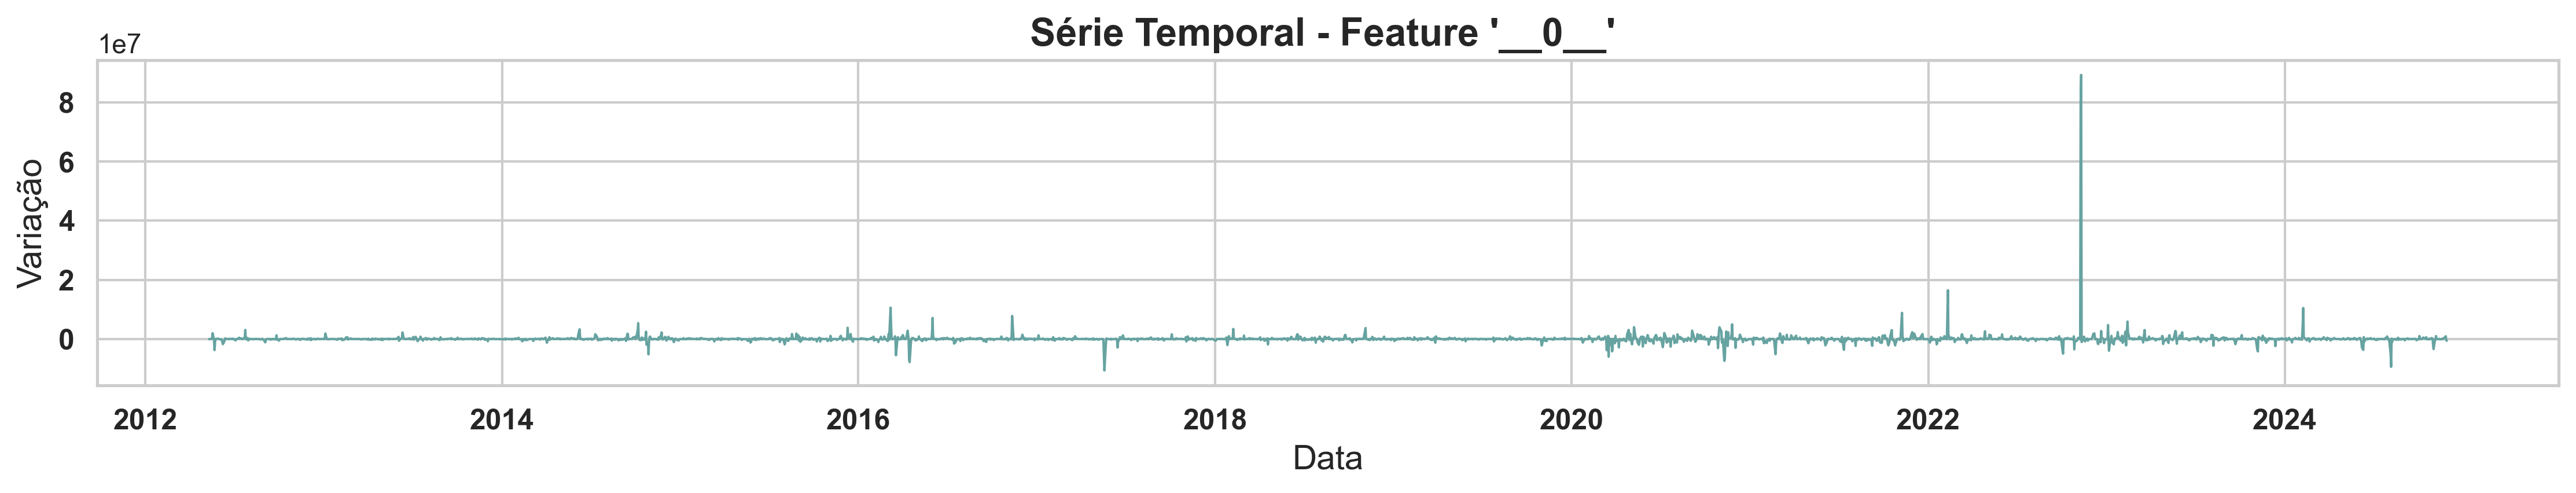

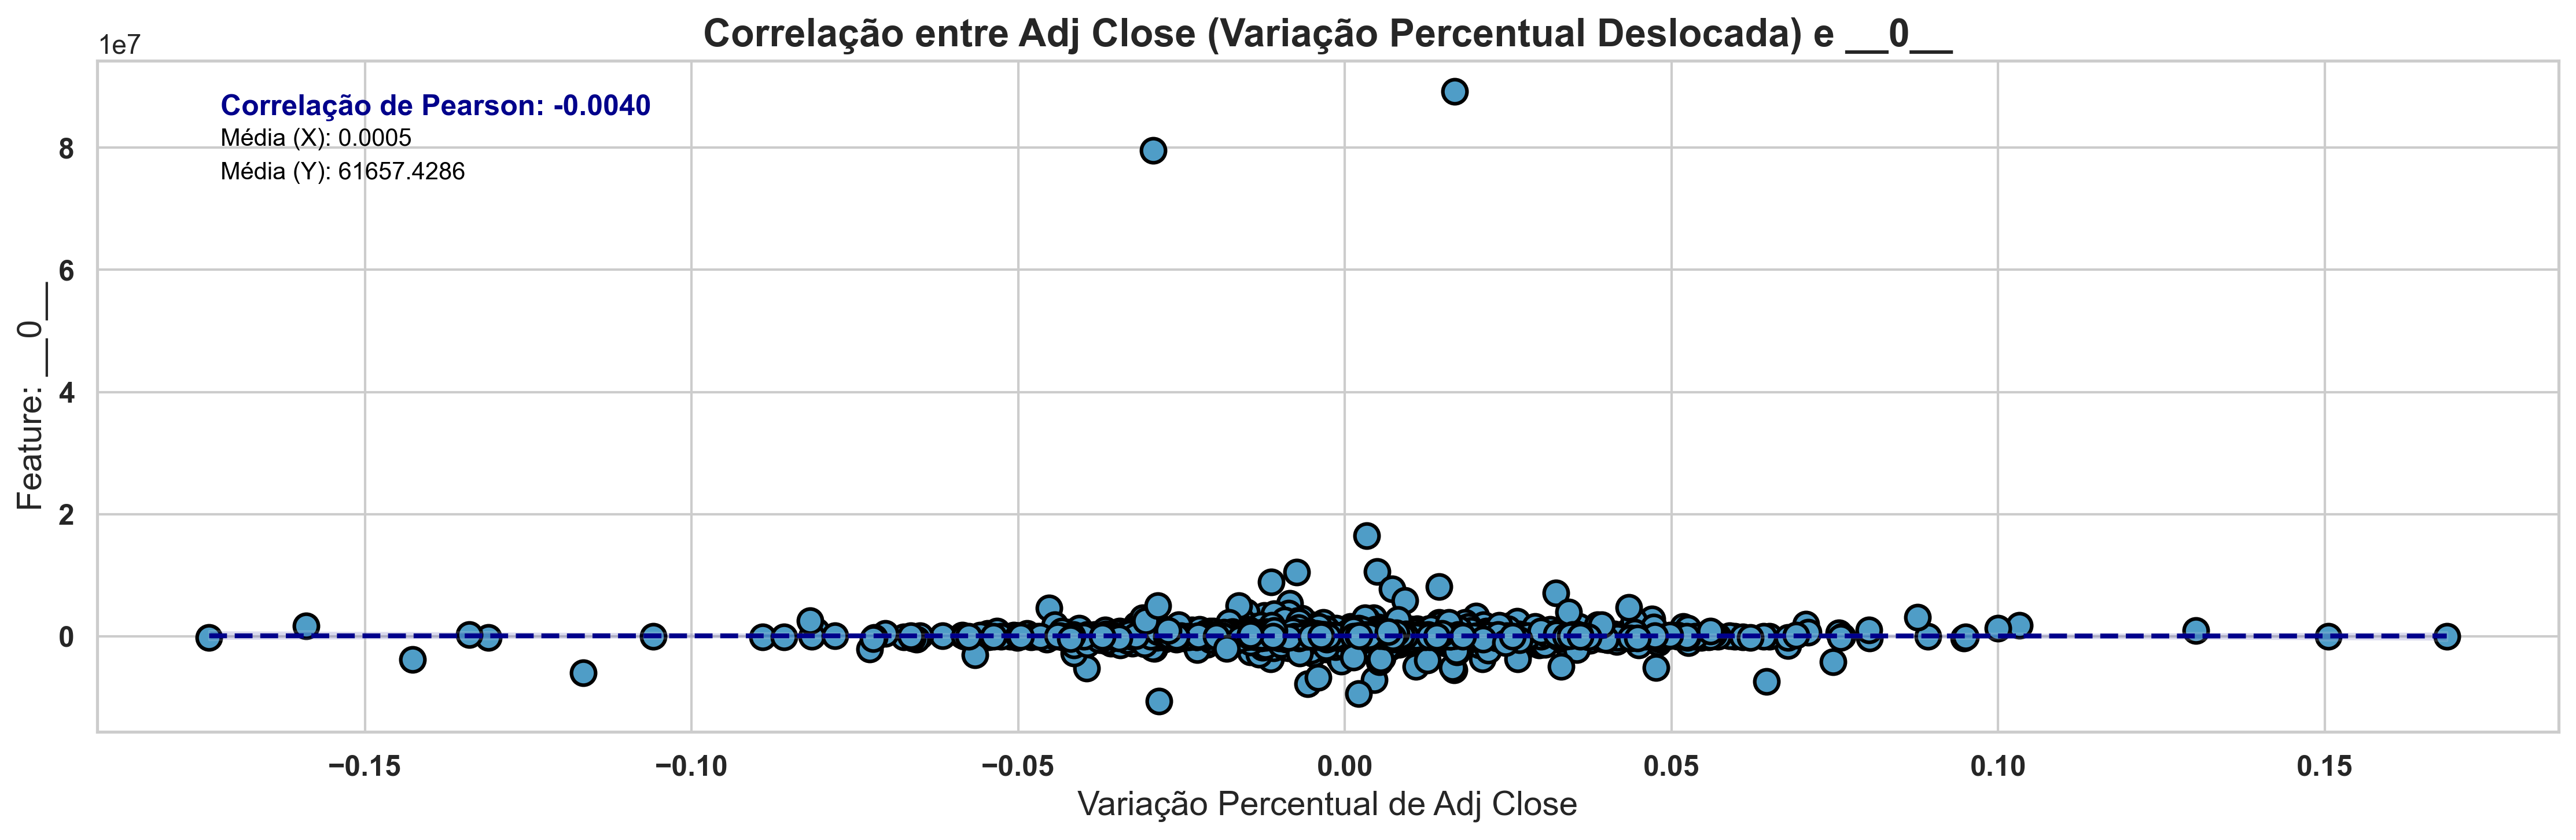

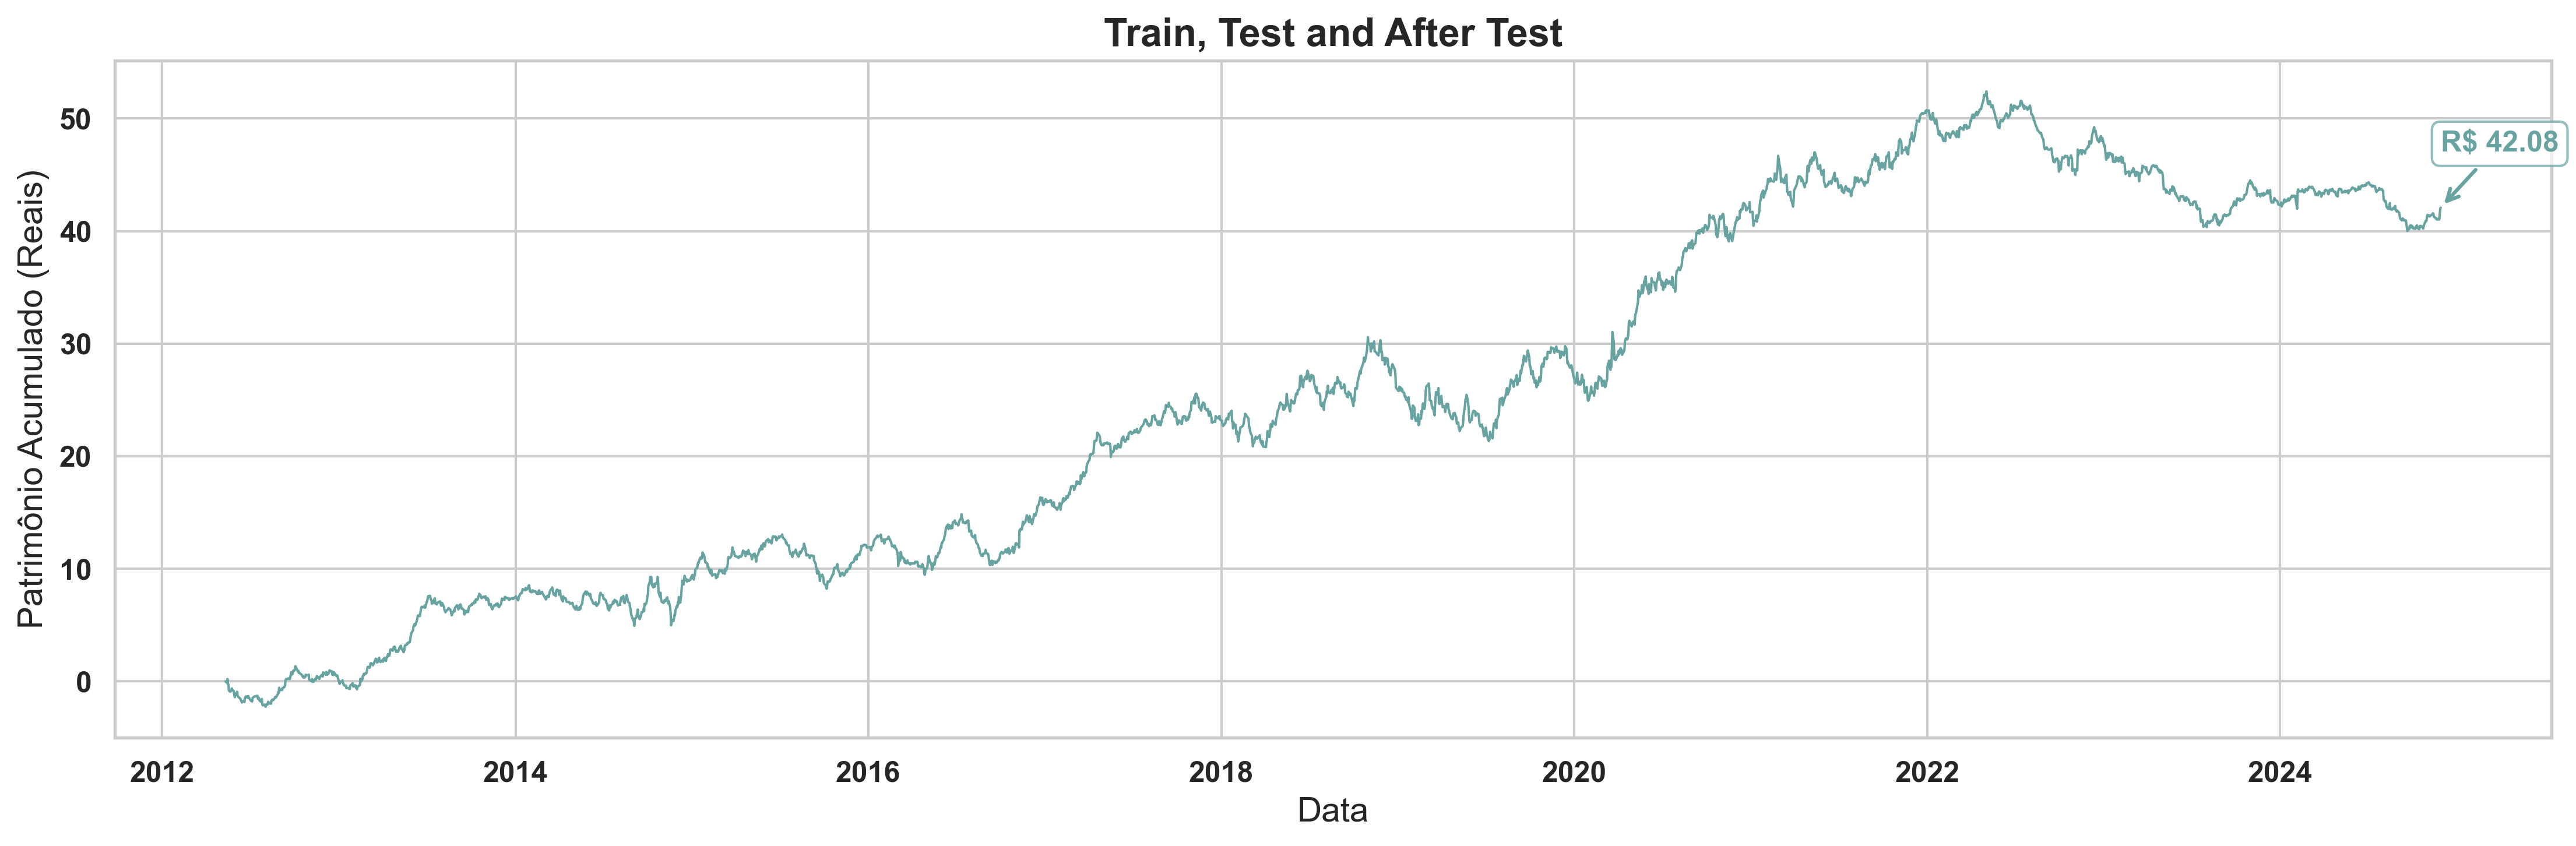

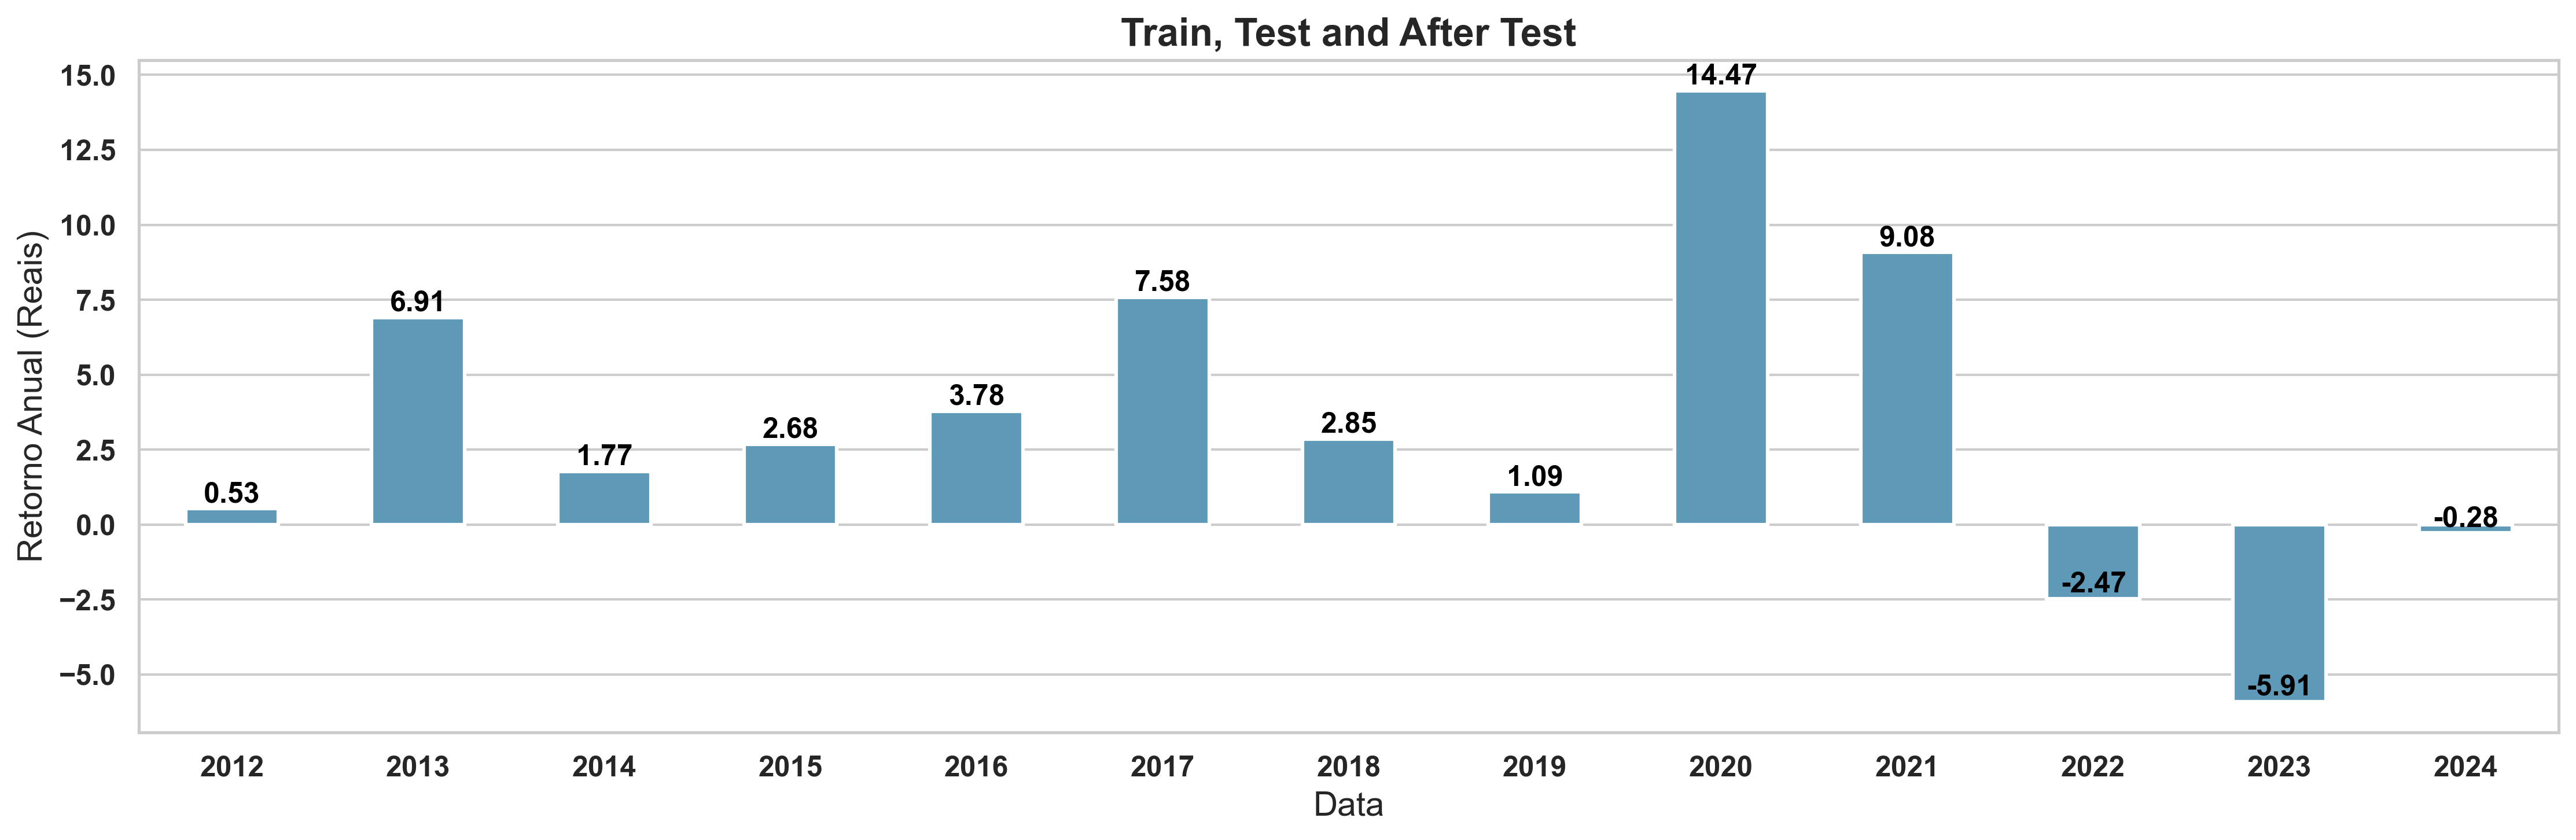

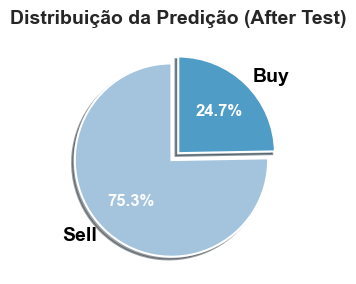

Qtd.dados:  3120


In [ ]:
ot = False

for _ in range(1, 20):
    
    # _ = _ + 1

    def __0__(df):

        volume = df['Volume']                                             
        adj_close = df['Adj Close'].pct_change(1)     
        close = df['Close'].pct_change(1)   
        open = df['Open'].pct_change(1)               
        low = df['Low'].pct_change(1)        
        high = df['High'].pct_change(1)       

        q = rolling_sum(S(J(low, 6, 0.10) - J(high, 6, 0.10), 6), 6)
        w = second_diff(adj_close) * second_diff(volume) * rolling_corr(q, adj_close)
        e = rolling_skew
        
        return w
    
    mb = MarketBehaviorForecaster('BBDC4.SA', p=1, features=None, start='2012-05-11', end='2022-05-11', step_size=None, enable_debug=True,
                                  contracts=0).run_forecast(
        external_variable=lambda df: __0__(df))

    if ot is False:
        print_dict(mb['metrics']['model'])
        mb['graphs'](mb['df']['df'], f'__0__', (15, 3), 1, ylabel='Variação', title=f"Série Temporal - Feature '__0__' ").linha()
        mb['graphs'](mb['df']['df'], ['Adj Close', f'__0__'], (15, 5), p=1).correlacao()
        mb['graphs'](mb['df']['df'], 'resultado_predicao_acumulado', (15, 5), 1, ylabel='Patrimônio Acumulado (Reais)', title='Train, Test and After Test', seta=True).linha()
        mb['graphs'](mb['df']['df'], 'resultado_predicao_acumulado', (15, 5), 1, ylabel='Retorno Anual (Reais)', title='Train, Test and After Test').barplot()
        mb['graphs'](mb['df']['df'][['predicao']], 'predicao', (3, 3), xlabel='', title=f"Distribuição da Predição (After Test)", fontsize_title=14, tick_params_labelsize=2).pio()
        print('Qtd.dados: ', len((mb['df']['df'])))
        break
    else:
        print_dict2(mb['metrics']['model'], _)
